<a href="https://colab.research.google.com/github/ImagingDataCommons/ai_medima_misc/blob/main/nnunet/notebooks/models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDC nnUNet Use-case: Results Visualization**

... and Brief Description here.

## **Environment Setup**

In [ ]:
import os
import sys
import pprint

# useful information
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("\nCurrent directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

print("Python version    :", sys.version.split('\n')[0])


Current directory : /content
Hostname          : 9673623f6e1b
Username          : root
Python version    : 3.7.13 (default, Mar 16 2022, 17:37:17) 


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage

bucket_name = 'idc-medima-paper'
project_name = "idc-sandbox-000"

# location where to store the data (and check if a patient was processed already)
# if a patient was processed already, copy over the segmentation and run only
# the post-processing (split the masks, etc.)
bucket_base_uri = "gs://%s/"%(bucket_name)

In [ ]:
# create the directory tree
!mkdir -p data 

!mkdir -p data/raw 
!mkdir -p data/raw/tmp data/raw/nsclc-radiomics
!mkdir -p data/raw/nsclc-radiomics/dicom

!mkdir -p data/processed
!mkdir -p data/processed/nsclc-radiomics
!mkdir -p data/processed/nsclc-radiomics/nrrd
!mkdir -p data/processed/nsclc-radiomics/nii
!mkdir -p data/processed/nsclc-radiomics/dicomseg

---

Evaluate quantitatively using [...]


In [318]:
import random
import numpy as np
import pandas as pd

from statsmodels.stats.anova import AnovaRM

from scipy.stats import pearsonr, spearmanr, ttest_rel

# ----------------------------------------

# everything that has to do with plotting goes here below
import seaborn as sns
sns.set(style = "whitegrid")

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import ListedColormap

%matplotlib inline
#%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a "color overlay" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

## ----------------------------------------

import plotly.express as px
import plotly.graph_objects as go

Set some paths and select the model we want to visualise the results of:

In [ ]:
data_base_path = "/content/data"
raw_base_path = "/content/data/raw/tmp"
sorted_base_path = "/content/data/raw/nsclc-radiomics/dicom"

processed_base_path = "/content/data/processed/nsclc-radiomics/"
processed_nrrd_path = os.path.join(processed_base_path, "nrrd")
processed_dicomseg_path = os.path.join(processed_base_path, "dicomseg")

bucket_output_base_uri = os.path.join(bucket_base_uri, "nnunet/nnunet_output")

# -----------------
# nnU-Net pipeline parameters

# model: choose from "2d", "3d_lowres", "3d_fullres", "3d_cascade_fullres"
# test-time augmentation: choose from "-tta" and "-no_tta"
compare_models_list = ["2d-no_tta", "2d-tta", 
                       "3d_lowres-no_tta", "3d_lowres-tta", 
                       "3d_cascade_fullres-no_tta",]

# sort it for consistency: (no-TTA)-(TTA) comparison between models
compare_models_list = sorted(compare_models_list)

In [ ]:
def generate_models_dict(compare_models_list, bucket_output_base_uri):

  """
  Function description here.

  Arguments:
    compare_models_list - required: 

  Returns:
    compare_models_dict   

  """

  compare_models_dict = dict()

  for nnunet_model in compare_models_list:
    
    compare_models_dict[nnunet_model] = dict()

    model_family = nnunet_model.split("-")[0]

    tta_str = "TTA" if "-tta" in nnunet_model else "no-TTA"

    experiment_folder_name = nnunet_model
    bucket_experiment_folder_uri = os.path.join(bucket_output_base_uri, experiment_folder_name)

    bucket_log_folder_uri = os.path.join(bucket_experiment_folder_uri, 'log')
    bucket_eval_folder_uri = os.path.join(bucket_experiment_folder_uri, 'eval')
    bucket_dicomseg_folder_uri = os.path.join(bucket_experiment_folder_uri, 'dicomseg')

    compare_models_dict[nnunet_model]["model_family"] = model_family
    compare_models_dict[nnunet_model]["tta_str"] = tta_str
    compare_models_dict[nnunet_model]["experiment_folder_name"] = experiment_folder_name
    compare_models_dict[nnunet_model]["bucket_log_folder_uri"] = bucket_log_folder_uri
    compare_models_dict[nnunet_model]["bucket_eval_folder_uri"] = bucket_eval_folder_uri
    compare_models_dict[nnunet_model]["bucket_dicomseg_folder_uri"] = bucket_dicomseg_folder_uri

  return compare_models_dict

In [ ]:
# populate a list of dictionaries with the models to compare and all
# the associated information needed to download the data from the buckets
compare_models_dict = generate_models_dict(compare_models_list = compare_models_list,
                                           bucket_output_base_uri = bucket_output_base_uri)

## **Function Definition**

Define some useful functions:

In [ ]:
def format_dict(df_dict, quantity_column_name):
  
  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:


  """

  for nnunet_model in df_dict:
  
    df = df_dict[nnunet_model][["PatientID", quantity_column_name]]

    try:
      data = data.merge(df, on = "PatientID", how = "left")
      data = data.rename(columns = {quantity_column_name : nnunet_model})
    except:
      data = df
      data = data.rename(columns = {quantity_column_name : nnunet_model})

  return data

In [ ]:
def comparison_boxplot(df_dict, quantity_column_name, quantity_name,
                       palette, fig_suptitle, ylim, add_beeswarm = False):

  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:

  """

  fig, ax_box  = plt.subplots(1, 1, figsize = (2.5*len(inference_time_df_dict), 6))

  data = format_dict(df_dict, quantity_column_name)

  sns.boxplot(data = data, ax = ax_box, width = 0.15, linewidth = .75, palette = palette)
  
  if add_beeswarm == True:
    sns.swarmplot(data = data, ax = ax_box, palette = palette, edgecolor = "black",
                  alpha = .5, size = 2.5)

  ax_box.set_ylim(ylim)
  ax_box.set_ylabel(quantity_name)

  _ = fig.suptitle(fig_suptitle)

In [ ]:
"""
Deprecated for now; example use:

---------------------------

dc_heart_df_dict = dict()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_heart_df = pd.read_csv(csv_path, index_col = [0])

  dc_heart_df_dict[nnunet_model] = dc_heart_df

---------------------------

comparison_boxplot(df_dict = dc_heart_df_dict,
                   quantity_column_name = "dc",
                   quantity_name = "Dice Similarity Coefficient (Heart)",
                   fig_suptitle = "Dice Similarity Coefficient (Heart)",
                   palette = palette,
                   add_beeswarm = False,
                   ylim = [0.5, 1])

"""

---

In [ ]:
def interactive_comparison_boxplot(df, quantity_name, palette, fig_title, ylim):

  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:

  """

  fig = px.box(df,
               color = "model",
               color_discrete_sequence = palette,
               points = "all", 
               hover_name = df.index,
               width = 1000, height = 700,
               title = fig_title,
               labels = {"model" : "nnU-Net Model",
                         "value" : quantity_name})

  fig.update_traces(width = 0.2, 
                    whiskerwidth = 0.4,
                    pointpos = -2)

  fig.update_layout(font = {"family" : "Times New Roman", "size" : 18},
                    paper_bgcolor = "rgba(0,0,0,0)",
                    plot_bgcolor = "rgba(0,0,0,0)",
                    showlegend = False)

  fig.update_xaxes(showgrid = True,
                   gridwidth = 1, gridcolor = "lightgray",
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True)

  fig.update_yaxes(range = ylim, showgrid = True,
                   gridwidth = 1, gridcolor = 'lightgray',
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True)
  
  fig.show()

---

In [ ]:
def interactive_scatterplot(df, models_to_compare, xlim, ylim, fig_title):

  """
  Function description here.

  Arguments:
    df               - required : 
    model_to_compare - required : x and y

  Outputs:

  """
  
  max_xy = max(xlim + ylim)

  fig_line = px.line(x = [0, max_xy], y = [0, max_xy])
  fig_line.update_traces(line = {"color" : 'lightgray',
                                 "width" : 1})

  fig_scatter = px.scatter(df,
                           x = models_to_compare[0],
                           y = models_to_compare[1],
                           hover_data = ["PatientID"],
                           trendline = "ols",
                           trendline_color_override = "gray",
                           color_discrete_sequence = [px.colors.qualitative.D3[0]])

  # update trend line
  for  k, trace  in enumerate(fig_scatter.data):
    if trace.mode is not None and trace.mode == 'lines':
      fig_scatter.data[k].update({"line_width" : 1,
                                  "line_dash" : "dot"})

  fig = go.Figure(data = fig_line.data + fig_scatter.data)

  fig.update_layout(font = {"family" : "Times New Roman", "size" : 18},
                    paper_bgcolor = "rgba(0,0,0,0)",
                    plot_bgcolor = "rgba(0,0,0,0)",
                    autosize = False,
                    width = 800,
                    height = 800,
                    title = fig_title)

  fig.update_traces(marker = {"size" : 8,
                              "line" : {"width" : 1,
                                        "color" : 'DarkSlateGrey'}},
                    selector = {"mode" : "markers"})

  fig.update_xaxes(range = xlim, showgrid = True,
                   gridwidth = 1, gridcolor = "lightgray",
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True,
                   title = models_to_compare[0])

  fig.update_yaxes(range = ylim, showgrid = True,
                   gridwidth = 1, gridcolor = 'lightgray',
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True,
                   title = models_to_compare[1])

  fig.show()

---

In [351]:
def spearman_pval(x, y):

  """
  Function description here.

  Outputs:

  """

  return spearmanr(x,y)[1]

## ----------------------------------------

def pearson_pval(x,y):

  """
  Function description here.

  Outputs:

  """

  return pearsonr(x,y)[1]

## ----------------------------------------

def viz_correlation_matrix(df, corr_method, fig_suptitle):
  
  """
  Function description here.

  Arguments:
    df        - required : 
    corr_cmap - required : x and y

  Outputs:

  """

  fig, (ax_corr, ax_pval) = plt.subplots(1, 2, figsize = (11, 6))

  if corr_method.lower() == "spearman":
    corr_df = df.corr(method = "spearman")
    pval_df = df.corr(method = spearman_pval)

  elif corr_method.lower() == "pearson":
    corr_df = df.corr(method = "pearson")
    pval_df = df.corr(method = pearson_pval)

  sns.heatmap(corr_df,
              cmap = sns.color_palette("light:r", as_cmap = True),
              annot = True,
              cbar = False,
              linewidth = 3,
              linecolor = "white",
              square = True,
              ax = ax_corr)

  sns.heatmap(pval_df,
              cmap = sns.light_palette("seagreen", reverse = True, as_cmap = True),
              annot = True,
              cbar = False,
              linewidth = 3,
              linecolor = "white",
              square = True,
              ax = ax_pval,
              yticklabels = False)
  
  ax_corr.set_title("Correlation Coefficient")
  ax_pval.set_title("p value")
  
  ax_corr.set_xlabel("")
  ax_corr.set_ylabel("")

  ax_pval.set_xlabel("")
  ax_pval.set_ylabel("")

  fig.subplots_adjust(wspace = 0.1)
  
  _ = fig.suptitle(fig_suptitle)

---

In [323]:
def generate_pval_mat_df(df, stat_test_func = ttest_rel):

  pval_dict = {x: {y: stat_test_func(df[x], df[y]).pvalue for y in df} for x in df}
  pval_df = pd.DataFrame(pval_dict)

  return pval_df

In [343]:
def viz_pval_matrix(df, fig_suptitle):
  
  """
  Function description here.

  Arguments:
    df        - required : 
    corr_cmap - required : x and y

  Outputs:

  """

  fig, ax_pval = plt.subplots(1, 1, figsize = (6, 6))

 
  pval_df = generate_pval_mat_df(df = df)

  # mask for the upper triangle of the matrix
  upper_triangle_mask = np.triu(pval_df)

  sns.heatmap(pval_df,
              cmap = sns.light_palette("seagreen", reverse = True, as_cmap = True),
              annot = True,
              cbar = False,
              linewidth = 3,
              linecolor = "white",
              square = True,
              ax = ax_pval,
              mask = upper_triangle_mask)
  
  ax_pval.set_xlabel("")
  ax_pval.set_ylabel("")
  
  fig.subplots_adjust(hspace = 0)

  _ = fig.suptitle(fig_suptitle)

---

Define a palette:

In [ ]:
palette = random.sample(population = px.colors.qualitative.T10,
                        k = len(compare_models_list))

---

# **Processing Time**

In [ ]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "inference_time.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_log_folder_uri = compare_models_dict[nnunet_model]["bucket_log_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_log_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/log/inference_time.csv...
/ [1/1 files][ 11.0 KiB/ 11.0 KiB] 100% Done                                    
Operation completed over 1 objects/11.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/log/inference_time.csv...
/ [1/1 files][ 11.3 KiB/ 11.3 KiB] 100% Done                                    
Operation completed over 1 objects/11.3 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_cascade_fullres-no_tta/log/inference_time.csv...
/ [1/1 files][ 11.1 KiB/ 11.1 KiB] 100% Done                                    
Operation completed over 1 objects/11.1 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/log/inference_time.csv...
/ [1/1 files][ 11.0 KiB/ 11.0 KiB] 100% Done                                    
Operation completed over 1 objects/11.0 KiB.                  

## **Interactive Boxplot**

In [ ]:
# prep data for plotly express plot - long dataframe
inference_time_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  inference_time_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  inference_time_df["inference_time_minutes"] = inference_time_df["inference_time"]/60
  inference_time_df["model"] = nnunet_model

  inference_time_df_all = pd.concat([inference_time_df_all, inference_time_df])

# long to wide dataframe
inference_time_df_all = inference_time_df_all.pivot_table(index = "PatientID",
                                                          columns = "model",
                                                          values = "inference_time_minutes")

In [317]:
interactive_comparison_boxplot(df = inference_time_df_all,
                               quantity_name = "Inference Time (minutes)",
                               palette = palette,
                               fig_title = "Inference time for different nnU-Net models",
                               ylim = [0, 15])

## **RM-ANOVA**

Start by running a Repeated Measures (RM) ANOVA analysis:
* Null hypothesis: groups means are equal

$$H0: \mu_1 = \mu_2 = \ ... \ = \mu_p$$

* Alternative hypothesis: at least one group mean is different from other groups (proceed with parametric or non-parametric pair-wise paired statistical testing)

$$H1: \exists \ i \ \text{s.t.} \ \mu_i \neq \mu_k \ (\text{for} \ k \neq i)$$

In [177]:
# reshape the d dataframe suitable for statsmodels package 
inference_time_df_all_melt = pd.melt(inference_time_df_all.reset_index(),
                                     id_vars = ['PatientID'],
                                     value_vars = compare_models_list)

# replace column names
inference_time_df_all_melt.columns = ['PatientID', 'model', 'inference_time']

In [179]:
model = AnovaRM(data = inference_time_df_all_melt,
                depvar = "inference_time",
                subject = "PatientID",
                within = ["model"])
res = model.fit()

print(res)

                 Anova
       F Value  Num DF   Den DF  Pr > F
---------------------------------------
model 6039.6035 4.0000 1424.0000 0.0000



---

# **Dice Similarity Coefficient**

## **Heart**

In [ ]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "dc_heart.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_cascade_fullres-no_tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      


### **Interactive Boxplot**

In [ ]:
# prep data for plotly express plot - long dataframe
dc_heart_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_heart_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  dc_heart_df["model"] = nnunet_model

  dc_heart_df_all = pd.concat([dc_heart_df_all, dc_heart_df])

# long to wide dataframe
dc_heart_df_all = dc_heart_df_all.pivot_table(index = "PatientID",
                                              columns = "model",
                                              values = "dc")

In [ ]:
interactive_comparison_boxplot(df = dc_heart_df_all,
                               quantity_name = "Dice Similarity Coefficient",
                               palette = palette,
                               fig_title = "Dice Similarity Coefficient (Heart) for different nnU-Net models",
                               ylim = [0, 1])

### **Stats**

#### **RM-ANOVA**

Start by running a Repeated Measures (RM) ANOVA analysis:
* Null hypothesis: groups means are equal

$$H0: \mu_1 = \mu_2 = \ ... \ = \mu_p$$

* Alternative hypothesis: at least one group mean is different from other groups (proceed with parametric or non-parametric pair-wise paired statistical testing)

$$H1: \exists \ i \ \text{s.t.} \ \mu_i \neq \mu_k \ (\text{for} \ k \neq i)$$

In [182]:
# reshape the d dataframe suitable for statsmodels package 
dc_heart_df_all_melt = pd.melt(dc_heart_df_all.reset_index(),
                               id_vars = ['PatientID'],
                               value_vars = compare_models_list)

# replace column names
dc_heart_df_all_melt.columns = ['PatientID', 'model', 'dc_heart']

In [183]:
model = AnovaRM(data = dc_heart_df_all_melt,
                depvar = "dc_heart",
                subject = "PatientID",
                within = ["model"])
res = model.fit()

print(res)

               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
model  1.4308 4.0000 504.0000 0.2225



#### **Pair-wise t-test**

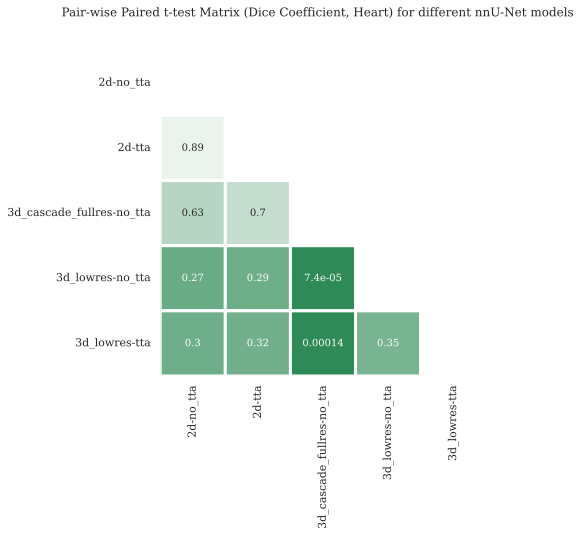

In [345]:
viz_pval_matrix(df = dc_heart_df_all, 
                fig_suptitle = "Pair-wise Paired t-test Matrix (Dice Coefficient, Heart) " \
                               "for different nnU-Net models")

#### **Correlation Analysis**

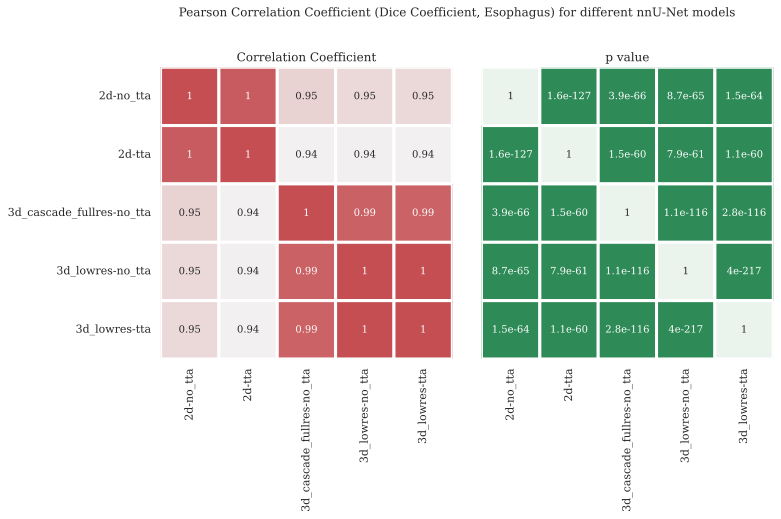

In [354]:
viz_correlation_matrix(df = dc_heart_df_all,
                       corr_method = "pearson",      
                       fig_suptitle = "Pearson Correlation Coefficient (Dice Coefficient, Esophagus) " \
                                      "for different nnU-Net models")

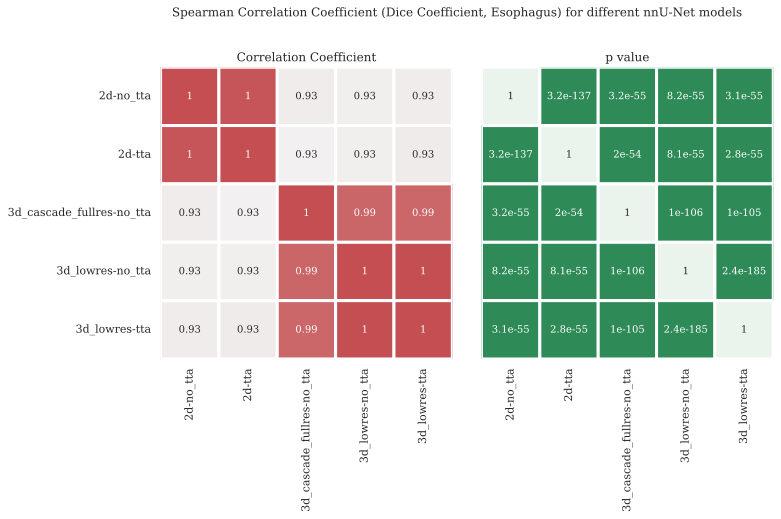

In [355]:
viz_correlation_matrix(df = dc_heart_df_all,
                       corr_method = "spearman",      
                       fig_suptitle = "Spearman Correlation Coefficient (Dice Coefficient, Esophagus) " \
                                      "for different nnU-Net models")

### **Scatterplot (model-model)**

In [ ]:
df = format_dict(df_dict = dc_heart_df_dict,
                 quantity_column_name = "dc")

interactive_scatterplot(df = df,
                        models_to_compare = ["2d-no_tta",
                                             "3d_cascade_fullres-no_tta"],
                        fig_title = "Dice Similarity Coefficient (Heart)",
                        xlim = [0.5, 1], ylim = [0.5, 1])

## **Esophagus**

In [327]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "dc_esophagus.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_cascade_fullres-no_tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                      

### **Interactive Boxplot**

In [328]:
# prep data for plotly express plot - long dataframe
dc_esophagus_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_esophagus_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  dc_esophagus_df["model"] = nnunet_model

  dc_esophagus_df_all = pd.concat([dc_esophagus_df_all, dc_esophagus_df])

# long to wide dataframe
dc_esophagus_df_all = dc_esophagus_df_all.pivot_table(index = "PatientID",
                                                      columns = "model",
                                                      values = "dc")

In [329]:
interactive_comparison_boxplot(df = dc_esophagus_df_all,
                               quantity_name = "Dice Similarity Coefficient",
                               palette = palette,
                               fig_title = "Dice Similarity Coefficient (Esophagus) for different nnU-Net models",
                               ylim = [0, 1])

### **Stats**

#### **RM-ANOVA**

Start by running a Repeated Measures (RM) ANOVA analysis:
* Null hypothesis: groups means are equal

$$H0: \mu_1 = \mu_2 = \ ... \ = \mu_p$$

* Alternative hypothesis: at least one group mean is different from other groups (proceed with parametric or non-parametric pair-wise paired statistical testing)

$$H1: \exists \ i \ \text{s.t.} \ \mu_i \neq \mu_k \ (\text{for} \ k \neq i)$$

In [330]:
# reshape the d dataframe suitable for statsmodels package 
dc_esophagus_df_all_melt = pd.melt(dc_esophagus_df_all.reset_index(),
                                   id_vars = ['PatientID'],
                                   value_vars = compare_models_list)

# replace column names
dc_esophagus_df_all_melt.columns = ['PatientID', 'model', 'dc_esophagus']

In [331]:
model = AnovaRM(data = dc_esophagus_df_all_melt,
                depvar = "dc_esophagus",
                subject = "PatientID",
                within = ["model"])
res = model.fit()

print(res)

                Anova
      F Value Num DF   Den DF  Pr > F
-------------------------------------
model 48.8858 4.0000 1416.0000 0.0000



#### **Pairwise t-test**

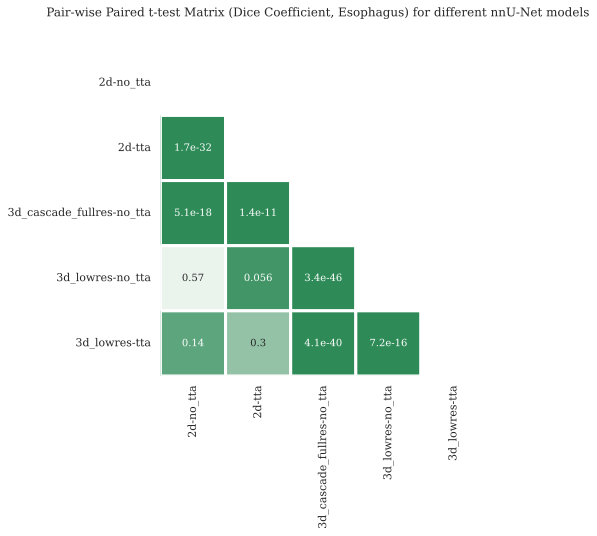

In [344]:
viz_pval_matrix(df = dc_esophagus_df_all, 
                fig_suptitle = "Pair-wise Paired t-test Matrix (Dice Coefficient, Esophagus) " \
                               "for different nnU-Net models")

#### **Correlation Analysis**

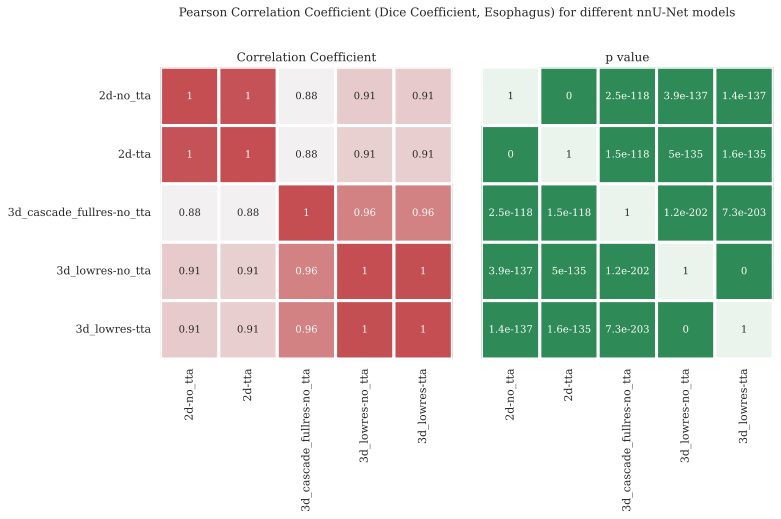

In [352]:
viz_correlation_matrix(df = dc_esophagus_df_all,
                       corr_method = "pearson",      
                       fig_suptitle = "Pearson Correlation Coefficient (Dice Coefficient, Esophagus) " \
                                      "for different nnU-Net models")

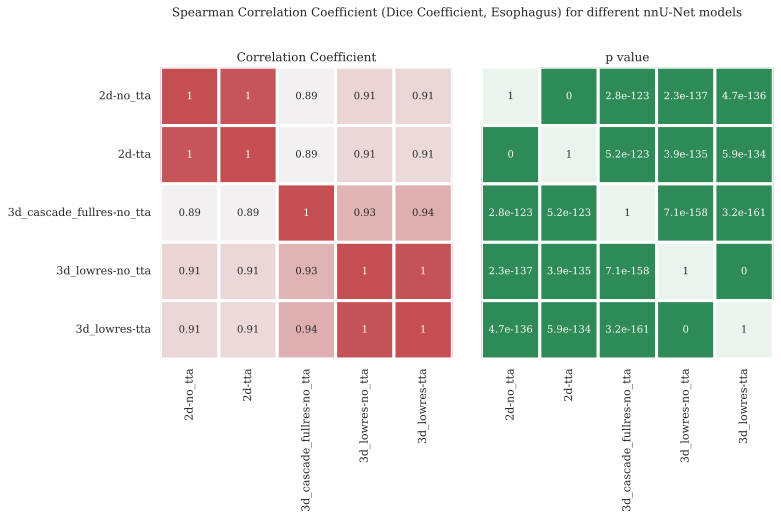

In [356]:
viz_correlation_matrix(df = dc_esophagus_df_all,
                       corr_method = "spearman",      
                       fig_suptitle = "Spearman Correlation Coefficient (Dice Coefficient, Esophagus) " \
                                      "for different nnU-Net models")

### **Scatterplot (model-model)**

In [ ]:
df = format_dict(df_dict = dc_esophagus_df_dict,
                 quantity_column_name = "dc")

interactive_scatterplot(df = df,
                        models_to_compare = ["2d-no_tta",
                                             "3d_cascade_fullres-no_tta"],
                        fig_title = "Dice Similarity Coefficient (Esophagus)",
                        xlim = [0, 1], ylim = [0, 1])

---

# **Hausdorff Coefficient**

## **Heart**

In [ ]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "hd_heart.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/hd_heart.csv...
/ [1/1 files][  5.8 KiB/  5.8 KiB] 100% Done                                    
Operation completed over 1 objects/5.8 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/hd_heart.csv...
/ [1/1 files][  5.8 KiB/  5.8 KiB] 100% Done                                    
Operation completed over 1 objects/5.8 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_cascade_fullres-no_tta/eval/hd_heart.csv...
/ [1/1 files][  5.5 KiB/  5.5 KiB] 100% Done                                    
Operation completed over 1 objects/5.5 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/hd_heart.csv...
/ [1/1 files][  5.6 KiB/  5.6 KiB] 100% Done                                    
Operation completed over 1 objects/5.6 KiB.                                      


### **Interactive Boxplot**

In [ ]:
# prep data for plotly express plot - long dataframe
hd_heart_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  hd_heart_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  hd_heart_df["model"] = nnunet_model

  hd_heart_df_all = pd.concat([hd_heart_df_all, hd_heart_df])

# long to wide dataframe
hd_heart_df_all = hd_heart_df_all.pivot_table(index = "PatientID",
                                              columns = "model",
                                              values = "hd95")

In [ ]:
interactive_comparison_boxplot(df = hd_heart_df_all,
                               quantity_name = "95th Percentile Hausdorff Distance",
                               palette = palette,
                               fig_title = "95th Percentile Hausdorff Distance (Heart) for different nnU-Net models",
                               ylim = [0, 25])

### **Stats**

#### **RM-ANOVA**

Start by running a Repeated Measures (RM) ANOVA analysis:
* Null hypothesis: groups means are equal

$$H0: \mu_1 = \mu_2 = \ ... \ = \mu_p$$

* Alternative hypothesis: at least one group mean is different from other groups (proceed with parametric or non-parametric pair-wise paired statistical testing)

$$H1: \exists \ i \ \text{s.t.} \ \mu_i \neq \mu_k \ (\text{for} \ k \neq i)$$

In [347]:
# reshape the d dataframe suitable for statsmodels package 
hd_heart_df_all_melt = pd.melt(hd_heart_df_all.reset_index(),
                                   id_vars = ['PatientID'],
                                   value_vars = compare_models_list)

# replace column names
hd_heart_df_all_melt.columns = ['PatientID', 'model', 'dc_esophagus']

In [348]:
model = AnovaRM(data = hd_heart_df_all_melt,
                depvar = "dc_esophagus",
                subject = "PatientID",
                within = ["model"])
res = model.fit()

print(res)

                Anova
      F Value Num DF   Den DF  Pr > F
-------------------------------------
model  1.5655 4.0000 1416.0000 0.1811



#### **Pairwise t-test**

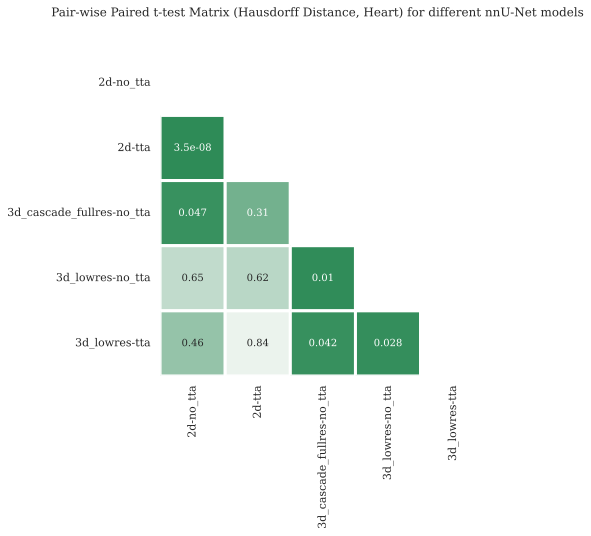

In [349]:
viz_pval_matrix(df = hd_heart_df_all, 
                fig_suptitle = "Pair-wise Paired t-test Matrix (Hausdorff Distance, Heart) " \
                               "for different nnU-Net models")

#### **Correlation Analysis**

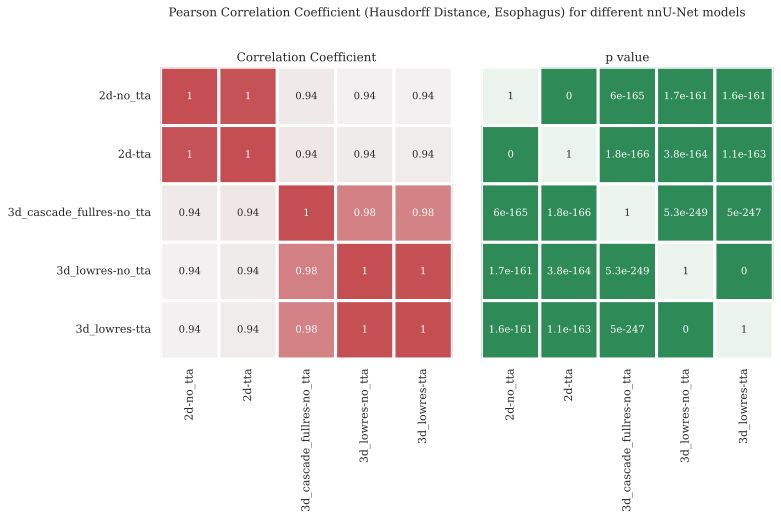

In [375]:
viz_correlation_matrix(df = hd_heart_df_all,
                       corr_method = "pearson",      
                       fig_suptitle = "Pearson Correlation Coefficient (Hausdorff Distance, Esophagus) " \
                                      "for different nnU-Net models")

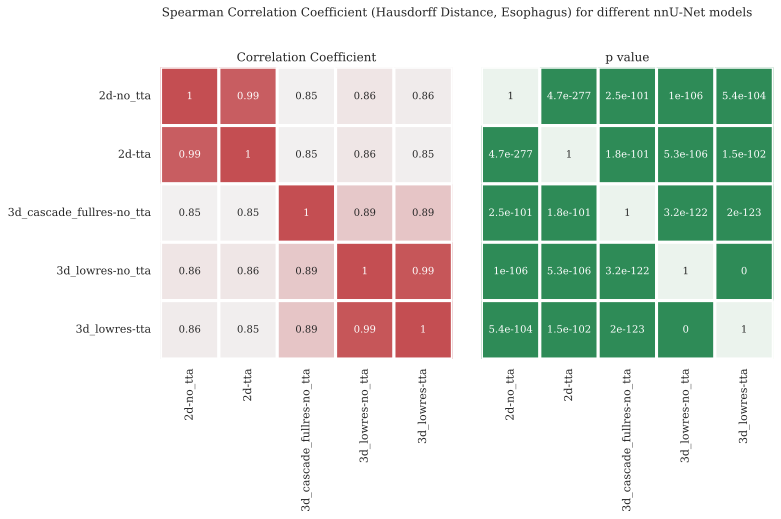

In [374]:
viz_correlation_matrix(df = hd_heart_df_all,
                       corr_method = "spearman",      
                       fig_suptitle = "Spearman Correlation Coefficient (Hausdorff Distance, Esophagus) " \
                                      "for different nnU-Net models")

### **Scatterplot (model-model)**

In [ ]:
df = format_dict(df_dict = hd_heart_df_dict,
                 quantity_column_name = "hd95")

interactive_scatterplot(df = df,
                        models_to_compare = ["2d-no_tta",
                                             "3d_cascade_fullres-no_tta"],
                        fig_title = "95th Percentile Hausdorff Distance (Heart)",
                        xlim = [0, 25], ylim = [0, 25])

## **Esophagus**

In [360]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "hd_esophagus.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/hd_esophagus.csv...
/ [1/1 files][ 18.0 KiB/ 18.0 KiB] 100% Done                                    
Operation completed over 1 objects/18.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/hd_esophagus.csv...
/ [1/1 files][ 18.0 KiB/ 18.0 KiB] 100% Done                                    
Operation completed over 1 objects/18.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_cascade_fullres-no_tta/eval/hd_esophagus.csv...
/ [1/1 files][ 17.5 KiB/ 17.5 KiB] 100% Done                                    
Operation completed over 1 objects/17.5 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/hd_esophagus.csv...
/ [1/1 files][ 18.0 KiB/ 18.0 KiB] 100% Done                                    
Operation completed over 1 objects/18.0 KiB.                      

### **Interactive Boxplot**

In [361]:
# prep data for plotly express plot - long dataframe
hd_esophagus_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  hd_esophagus_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  hd_esophagus_df["model"] = nnunet_model

  hd_esophagus_df_all = pd.concat([hd_esophagus_df_all, hd_esophagus_df])

# long to wide dataframe
hd_esophagus_df_all = hd_esophagus_df_all.pivot_table(index = "PatientID",
                                                      columns = "model",
                                                      values = "hd95")

In [363]:
interactive_comparison_boxplot(df = hd_esophagus_df_all,
                               quantity_name = "95th Percentile Hausdorff Distance",
                               palette = palette,
                               fig_title = "95th Percentile Hausdorff Distance (Esophagus) for different nnU-Net models",
                               ylim = [0, 50])

### **Stats**

#### **RM-ANOVA**

Start by running a Repeated Measures (RM) ANOVA analysis:
* Null hypothesis: groups means are equal

$$H0: \mu_1 = \mu_2 = \ ... \ = \mu_p$$

* Alternative hypothesis: at least one group mean is different from other groups (proceed with parametric or non-parametric pair-wise paired statistical testing)

$$H1: \exists \ i \ \text{s.t.} \ \mu_i \neq \mu_k \ (\text{for} \ k \neq i)$$

In [364]:
# reshape the d dataframe suitable for statsmodels package 
hd_esophagus_df_all_melt = pd.melt(hd_esophagus_df_all.reset_index(),
                                   id_vars = ['PatientID'],
                                   value_vars = compare_models_list)

# replace column names
hd_esophagus_df_all_melt.columns = ['PatientID', 'model', 'dc_esophagus']

In [365]:
model = AnovaRM(data = hd_esophagus_df_all_melt,
                depvar = "dc_esophagus",
                subject = "PatientID",
                within = ["model"])
res = model.fit()

print(res)

                Anova
      F Value Num DF   Den DF  Pr > F
-------------------------------------
model  1.5655 4.0000 1416.0000 0.1811



#### **Pairwise t-test**

In [368]:
hd_esophagus_df_all

model,2d-no_tta,2d-tta,3d_cascade_fullres-no_tta,3d_lowres-no_tta,3d_lowres-tta
PatientID,,,,,
LUNG1-002,10.728774,10.552482,8.860517,10.566743,10.733728
LUNG1-003,2.184639,2.184639,2.521773,2.069319,2.069319
LUNG1-004,12.679350,13.626550,17.000179,12.879609,12.982049
LUNG1-005,2.592319,2.592319,2.592319,2.999999,2.999999
LUNG1-006,5.190844,4.988500,5.394427,7.988500,8.004392
...,...,...,...,...,...
LUNG1-417,1.178815,0.976562,1.178815,1.667096,1.667096
LUNG1-418,1.667096,1.464844,1.464844,2.234615,2.190534
LUNG1-420,2.441406,2.501516,1.580111,2.234615,2.476562


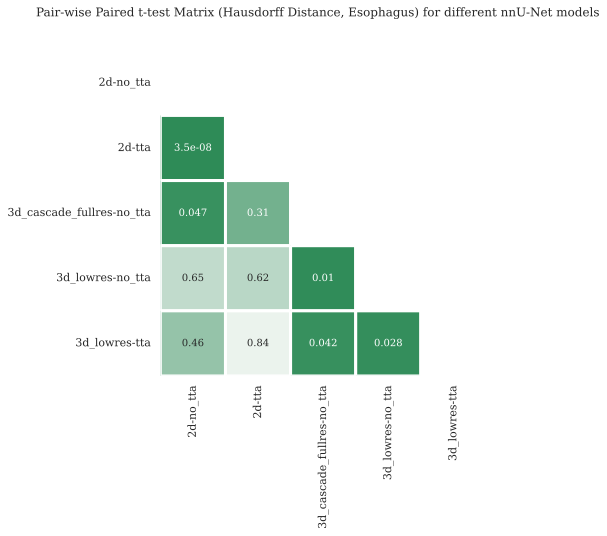

In [367]:
viz_pval_matrix(df = hd_esophagus_df_all, 
                fig_suptitle = "Pair-wise Paired t-test Matrix (Hausdorff Distance, Esophagus) " \
                               "for different nnU-Net models")

#### **Correlation Analysis**

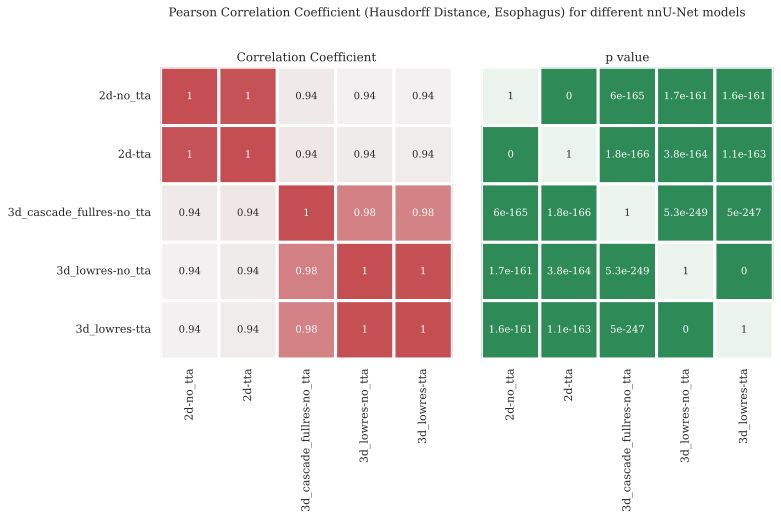

In [373]:
viz_correlation_matrix(df = hd_esophagus_df_all,
                       corr_method = "pearson",      
                       fig_suptitle = "Pearson Correlation Coefficient (Hausdorff Distance, Esophagus) " \
                                      "for different nnU-Net models")

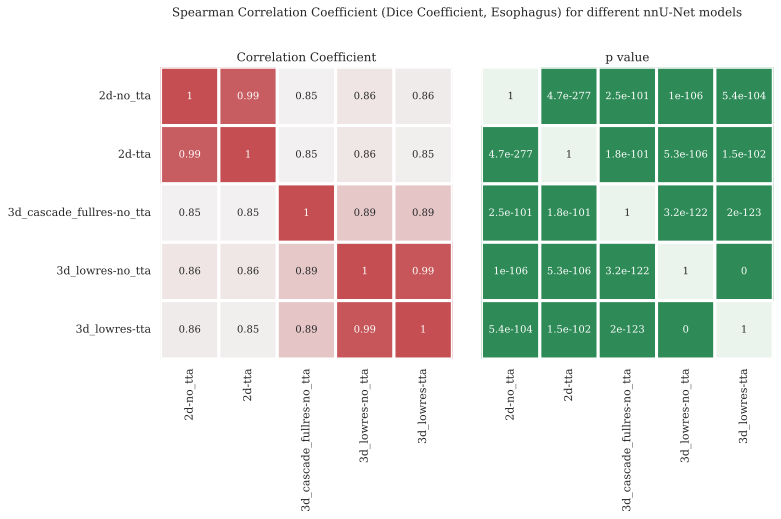

In [372]:
viz_correlation_matrix(df = hd_esophagus_df_all,
                       corr_method = "spearman",      
                       fig_suptitle = "Spearman Correlation Coefficient (Hausdorff Distance, Esophagus) " \
                                      "for different nnU-Net models")

### **Scatterplot (model-model)**

In [ ]:
df = format_dict(df_dict = hd_esophagus_df_dict,
                 quantity_column_name = "hd95")

interactive_scatterplot(df = df,
                        models_to_compare = ["2d-no_tta",
                                             "3d_cascade_fullres-no_tta"],
                        fig_title = "95th Percentile Hausdorff Distance (Esophagus)",
                        xlim = [0, 100], ylim = [0, 100])